Monitoring
===
This script produce time plots of temperature, humidity, trigger rate and accidental rate. Information taken from the parsing dictionary that reads the SLOWCONTROL file.

**Minimal requirement: Run parsing step**

To remove this requirements, it is necessary to read directly from the SLOWCONTROL file.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from muraves_lib import run_manager
from muraves_lib import file_handler
from datetime import datetime

# Function to search for json from parsing to have info about good and bad runs
import json


def is_good_run(root_path, range_run, color, parsing_version = 'v0') :
    file = []
    is_good = []

    for (run, col) in zip(range_run, color):
        try:
            with open(f'{root_path.replace("RAW_GZ", "PARSED")}/{col}/{parsing_version}/ADC_run{run}.json', "r", encoding="utf-8") as f:
                data = json.load(f)
                is_good.append(True if data.get("status")== "ok" else False)
                file.append(f"found")
        except FileNotFoundError:
            file.append("not found")
            is_good.append(False)
        
    return file, is_good

def time_plot(var, time, **kwargs):
    ref = kwargs.get('ref', None)
    xaxis = kwargs.get('xaxis', None)
    yaxis = kwargs.get('yaxis', None)
    title = kwargs.get('title', None)
    status = kwargs.get('status', None)   # ← NEW

    # Main plot
    fig = plt.figure(figsize=(10,5))
    ax_main = fig.add_axes([0.2, 0.2, 0.6, 0.6])  # left, bottom, width, height


    # --- BACKGROUND COLORING (NEW) ---
    if status is not None:
        for x, s in zip(time, status):
            if s is True:
                ax_main.axvspan(x - 0.5, x + 0.5, color="green", alpha=0.2)
            elif s is False:
                ax_main.axvspan(x - 0.5, x + 0.5, color="red", alpha=0.2)
            # "unknown" → no background
    # --------------------------------

    ax_main.plot(time, var, marker='.')
    if ref is not None:
        ax_main.plot(time,ref, marker='',  color='gray', linestyle='--')


    ax_main.set_xlabel(xaxis['label']) if xaxis else  ax_main.set_xlabel("Time")
    ax_main.set_ylabel(yaxis['label']) if yaxis else ax_main.set_ylabel("a.u.")
    ax_main.set_ylim(yaxis['range']) if yaxis and 'range' in yaxis else None
        

    if title: plt.title(title)
    fig.autofmt_xdate()   # rotate date labels
    ax_main.grid(True)
    plt.show()




def run_plots(
    run_range: list,
    dataframe: pd.DataFrame,
    raw_files_path: str,
    temperature=True,
    humidity=True,
    trigger_rate=True,
    accidental_rate=True

    
):


    dataframe = dataframe.query(f'run >= {run_range[0]} & run < {run_range[-1]+1}')
    dataframe = dataframe.sort_values(by='run')

    file, is_good = is_good_run(
    root_path=raw_files_path,
    range_run=dataframe["run"],
    color=dataframe["hodoscope"]
)
    
    dataframe["is_good"] = [ ig if f == "found" else "unknown" for f, ig in zip(file, is_good)]


    #for run in run_range:
    #    runs.append(run)
        
        #info = file_handler.read_run_info_from_json(
        #   parsed_files_path + f'ADC_run{run}.json'
        #)
        #info_list.append(info)

    trs          = dataframe["trigger_rate"] #extract_var("trigger_rate", info_list)
    ars          = dataframe["accidental_rate"] #extract_var("accidental_rate", info_list)
    times        = extract_time(list(dataframe["timestamp"]))
    temperatures = dataframe["temperature"] #extract_var("temperature", info_list)
    wps          = dataframe["wp"] #extract_var("working_point", info_list)

    if trigger_rate:
        time_plot(np.array(trs), np.array(run_range),
                        xaxis={'label': 'Run'},
                        yaxis={'label': 'Trigger Rate', 'range': (0, 30)},
                        status=dataframe["is_good"].tolist()  # ← NEW
                        )

    if accidental_rate:
        time_plot(np.array(ars), np.array(run_range),
                        xaxis={'label': 'Run'},
                        yaxis={'label': 'Accidental Rate'},
                        status=dataframe["is_good"].tolist()
                        )

    if temperature:
        time_plot(np.array(temperatures), np.array(times),
                        ref=np.array(wps),
                        xaxis={'label': 'Time'},
                        yaxis={'label': 'Temperature (°C)', 'range': (10, 30)},
                        status=dataframe["is_good"].tolist()
                        )
        


def extract_time(ts_list) -> list:
    """
    Given a list of run dictionaries, return a of times (human readable format):
    - times (datetime objects rounded to hours)
    - temperatures
    """

    times = []
    day = None



    for ts in ts_list:
        # convert milliseconds → seconds → datetime
        try:
            dt = datetime.fromtimestamp(ts / 1000.0)
            # round down to hour (drop minutes/seconds)
            dt_hour = dt.replace(second=0, microsecond=0)
            #converted_time = dt_hour.strftime("%Y-%m-%d %H:%M")
            #print("day", day)
            #print(converted_time.split(" ")[0])
            if day == dt_hour.strftime("%Y-%m-%d"):
                times.append(dt_hour.strftime("%H:%M"))
            else:
                day = dt_hour.strftime("%Y-%m-%d")
                times.append(dt_hour.strftime("%Y-%m-%d %H:%M"))

        except:
            times.append(None)
        

    return times

#def extract_var(var, data_list) -> list:
#    var_list =[]
#    for data in data_list:
#        value = data.get(var)
#
#        var_list.append(float(value))
#    
#    return var_list


In [5]:
#import plots

run_range = range(2500,2510,1)
temperature     = True
humidity        = False
trigger_rate    = True
accidental_rate = True

raw_files_path = '/group/Muography/abiolchi/test/RAW_GZ'
hodoscope_color = 'NERO'



dataframe = run_manager.create_database(raw_files_path, color_list=[hodoscope_color])
print(dataframe.head())


100%|██████████| 24/24 [00:00<00:00, 62.54it/s]


  hodoscope    run      timestamp         day   hour    wp  temperature  \
0      NERO   2507  1572143168320  2019-10-27  03:26  20.0         16.0   
1      NERO  10089  1630138733053  2021-08-28  10:18  25.0         26.2   
2      NERO   2501  1572121917353  2019-10-26  22:31  20.0         17.4   
3      NERO  11429  1656384927187  2022-06-28  04:55  25.0         29.2   
4      NERO  10081  1630104912386  2021-08-28  00:55  25.0         26.1   

   humidity  trigger_rate  accidental_rate orientation  
0      76.4        15.267              0.0    vesuvius  
1      69.6        11.467              0.0    vesuvius  
2      77.3        14.267              0.0    vesuvius  
3      34.5        11.450              0.0    vesuvius  
4      65.4        12.050              0.0    vesuvius  


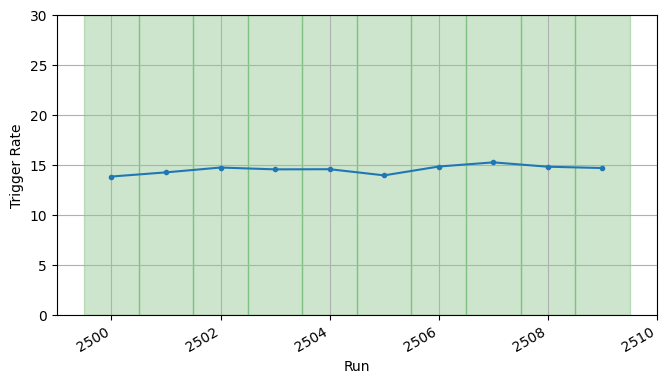

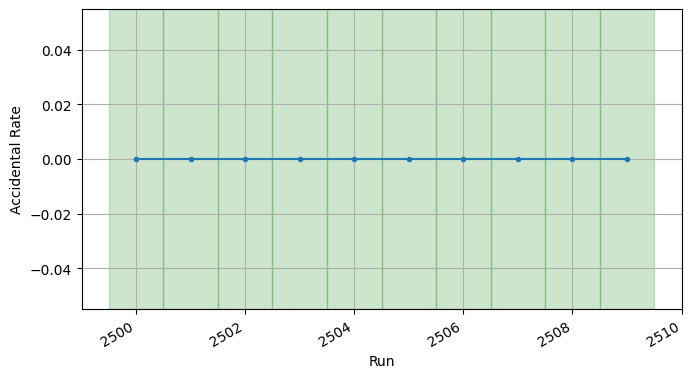

TypeError: unsupported operand type(s) for -: 'numpy.str_' and 'float'

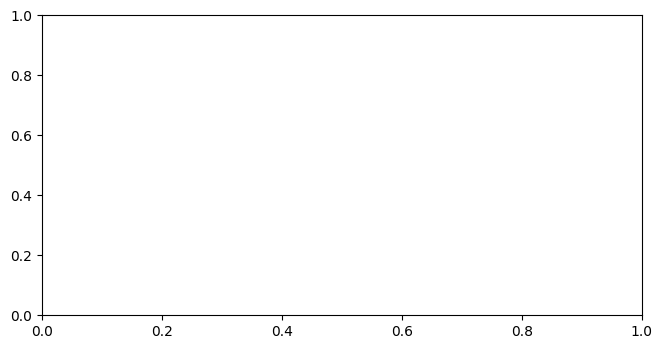

In [6]:
run_plots(run_range, dataframe, temperature=temperature, humidity=humidity, trigger_rate=trigger_rate, accidental_rate=accidental_rate, raw_files_path=raw_files_path)